#Classification of bird species<br/>
##Image detection Project 2021-2022<br/>

Matteo Cesaro - matteo.t.cesaro@gmail.com<br/>
Francesco Martinelli <br/>
Cristiano Ruttico <br/>

The notebook is connected to the drive containing the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


We import all the libraries necessary to process the data and build the model. Finally we define a function used in the evaluation of the model called "plot_history".

In [ ]:
!pip3 install scikeras

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.10.0
    Uninstalling importlib-metadata-4.10.0:
      Successfully uninstalled importlib-metadata-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.


In [ ]:
# Base Library
import numpy as np

# Manage file
from time import time
from shutil import copyfile
import tarfile
import os

# Visualizations
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow

# Manage Data
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Import base Model
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# Model Specialization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, initializers
from tensorflow.keras import layers
from tensorflow.python.keras.layers.core import Dropout
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam, SGD

# Ottimizzatore iperparametri
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense

In [ ]:
# Loss and accuracy Graph
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Top 3 Accuracy')
    plt.plot(x_plot, network_history.history['top_k_categorical_accuracy'])
    plt.plot(x_plot, network_history.history['val_top_k_categorical_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


#FILE MANAGING

You copy the compressed dataset to the machine used in Cloud and extract it.

In [ ]:
# copyfile('/content/gdrive/.../CUB_200_2011.tgz', 'CUB_200_2011.tgz')

'CUB_200_2011.tgz'

In [ ]:
t0 = time()
tar = tarfile.open('CUB_200_2011.tgz')
tar.extractall()
tar.close()
print("File transfer completed in %0.3f seconds" % (time() - t0))

File transfer completed in 21.356 seconds


A variable is assigned the list of objects present in the "images" folder of the dataset in alphabetical order. The objects in question are the folders that contain the images related to a particular species, the name of the species in question is the name of the folder itself.

In [ ]:
it = os.listdir("CUB_200_2011/images")
it.sort()
root_dir = "CUB_200_2011/images/"

In [ ]:
it[0:5]

['001.Black_footed_Albatross',
 '002.Laysan_Albatross',
 '003.Sooty_Albatross',
 '004.Groove_billed_Ani',
 '005.Crested_Auklet']

#PREPROCESSING

In the following loop the images of the dataset are imported and processed. The loop explores inside the folder "images" and for each folder (i.e. for each class) imports the images and preprocesses them. At the same time for each imported image it assigns the corresponding label to a list ("ds_lab"), thus populating the label dataset. For reasons of computational capacity the imported images were only 45 out of about 60 available for each class.

The target size of the input is (224,224) because for the subsequent implementation of transfer learning is indicated that the images respect the input size of the original architecture and also the preprocessing of the architecture.

In [ ]:
#Defining a compact preprocessing function
categories = it

#Nel ds avremo array di tipo numpy relativi alle immagini
ds = []
#Nel ds_lab le etichette(label) relative alle immagini in ordine di indice
ds_lab = []

i = 0

for ctg in categories:
  path = root_dir + ctg
  items = os.listdir(path)
  count = 0 
  for itm in items:  
    if count == 45:
        break
    else:
        path_img = path+"/"+itm
        # data loading = setta tutte le immagini modificando la shape
        img = image.load_img(path_img, target_size=(224,224))
        # from image to array of pixel 
        img = image.img_to_array(img)
        img= np.array(img, dtype=int)
        # preprocessing of image by resnet 50
        # Eventualmente puoi farla anche nella specializzazione del modello
        img = preprocess_input(img)
        ds.append(img)
        ds_lab.append(i)
        count += 1

         
  i += 1

The lists are converted to numpy arrays for computational purposes and are randomized for later partitioning into Training Sets and Test Sets.

In [ ]:
#Conversione da lista in np.array dei risultati
ds = np.array(ds)
ds_lab = np.array(ds_lab)

ds, ds_lab = shuffle(ds, ds_lab)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


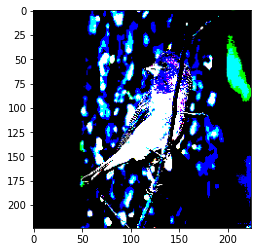

In [ ]:
imshow(ds[17]);

##TRAIN AND TEST SPLITTING

The split into Training Set and Test Set is made with proportions 70% Training Set and 30% Test Set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ds, ds_lab, test_size=0.3, random_state=210)

In [ ]:
#Necessario per la RAM
ds, ds_lab = [0,0]

##ONE-HOT ENCODING

To improve the performances and to favor the construction of the model the One-Hot Encoding of the class labels of both the training set and the test set is applied. We thus go from a k-dimensional vector to a matrix of dimension kxn where n is the number of classes.

In [ ]:
#Modifico le label convertendo il formato numerico in categorico
num_classes = 200



print('y_train_shape:', y_train.shape)
y_train = keras.utils.to_categorical(y_train, num_classes)
print('y_train_shape:', y_train.shape)

print('y_test_shape:', y_test.shape)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_test_shape:', y_test.shape)

y_train_shape: (6296,)
y_train_shape: (6296, 200)
y_test_shape: (2699,)
y_test_shape: (2699, 200)


#BASE_MODEL LOADING

https://keras.io/applications/

The architecture used to implement the feature extraction is imported and shown. It is the ResNet50 architecture with the weights related to the ImageNet Challenge.

In [ ]:
base_model = ResNet50(weights="imagenet")
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#FEATURE EXTRACTION

The ResNet architecture is cut to the Global Average Pooling Layer "avg_pool". This layer is close to the output and is therefore indicated, given the similarity between the tasks.

In [ ]:
model1 = keras.Sequential()
model1.add(Model(inputs = base_model.input, outputs = base_model.get_layer('avg_pool').output)) 
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


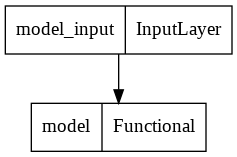

In [ ]:
keras.utils.plot_model(model1)

Features are extracted on the training set and test set data that will then be used in the training and evaluation of the model.

In [ ]:
feature1 = model1.predict(X_train)
X_train = 0

In [ ]:
test1 = model1.predict(X_test)
X_test = 0

# HYPERPARAMETERS SETTING 

For the setting of the hyperparameters a prototype of the model built later is set and the GridSearch is implemented to find with a brute force method the most performing setting of the hyperparameters. Some variables have been set a priori, for example the loss functions and the optimizer (respectively the categorical crossentropy and Adam).

In [ ]:
initializer = initializers.GlorotUniform(seed=3)

In [ ]:
'''
start=time()
def create_mlp_model(learning_rate=0.0003):
    # create model
    model = Sequential()
    model.add(Dense(2048, activation='relu', kernel_initializer=initializer , input_shape=(None,2048))) 
    model.add(Dense(200, activation='softmax', kernel_initializer=initializer)) 
    # add a dropout layer if rate is not null
    
    # Compile model
    model.compile( 
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )    
    return model


# define function to display the results of the grid search
def display_cv_results(search_results):
    print('Best score = {:.4f} using {}'.format(search_results.best_score_, search_results.best_params_))
    means = search_results.cv_results_['mean_test_score']
    stds = search_results.cv_results_['std_test_score']
    params = search_results.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))


# create model
model = KerasClassifier(build_fn=create_mlp_model, verbose=1,learning_rate=0.0003) 

# define parameters and values for grid search 
param_grid = {
    'batch_size': [64, 128],
    'epochs': [100, 128],
    'learning_rate': [0.0001, 0.00008]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(feature1, y_train)  # fit the full dataset as we are using cross validation

print('time for grid search = {:.0f} sec'.format(time()-start))
display_cv_results(grid_result)

'''

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/128
99/99 [==============================] - 1s 8ms/step - loss: 4.5823 - accuracy: 0.1193
Epoch 2/128
99/99 [==============================] - 1s 8ms/step - loss: 2.7762 - accuracy: 0.4431
Epoch 3/128
99/99 [==============================] - 1s 8ms/step - loss: 1.8227 - accuracy: 0.6317
Epoch 4/128
99/99 [==============================] - 1s 8ms/step - loss: 1.3157 - accuracy: 0.7400
Epoch 5/128
99/99 [==============================] - 1s 8ms/step - loss: 1.0119 - accuracy: 0.8059
Epoch 6/128
99/99 [==============================] - 1s 7ms/step - loss: 0.8000 - accuracy: 0.8653
Epoch 7/128
99/99 [==============================] - 1s 8ms/step - loss: 0.6475 - accuracy: 0.9009
Epoch 8/128
99/99 [==============================] - 1s 7ms/step - loss: 0.5324 - accuracy: 0.9293
Epoch 9/128
99/99 [==============================] - 1s 7ms/step - loss: 0.4412 - accuracy: 0.9482
Epoch 10/128
99/99 [==============================] - 1s 7ms/step - loss: 0.3718 - accuracy: 0.9635
Epoch 11/

Based on the Grid Search results, hyperparameters are set.

In [ ]:
n_epochs = 128
batch_size = 64
l_rate = 0.00008

Finally the hyperparameters for L2 regularization and validation split are set. The Gaussian Noise layer is imported in order to obtain a better regularization of the model.

In [ ]:
lam = 0.0005
validation_split = 0.1

In [ ]:
# import noise layer
from keras.layers import GaussianNoise

# TRAINING

The classifier is trained. Drop-out layers and a gaussian noise layer were added in order to obtain a better generalization of the model given the tendency to overfitting demonstrated during the Grid Search. The settings of the drop-out values were 0.7 for the input layer and 0.2 for the output layer. Also for generalization, the L2 weights penalty was implemented.

The input layer was added to offer more discerning capacity to the model, as activation function was used ReLu, which tends to have good results in this type of classification. 

In [ ]:
classifier1 = keras.Sequential(
    [
     layers.GaussianNoise(0.1),
     layers.Dropout(0.7),
     layers.Dense(2048, input_shape=(2048,), activation= "relu", kernel_initializer=initializer , kernel_regularizer=regularizers.l2(lam)),
     layers.Dropout(0.2),
     layers.Dense(num_classes, activation= "softmax", kernel_initializer=initializer , kernel_regularizer=regularizers.l2(lam)),
    ]
)

In [ ]:
import tensorflow as tf

In [ ]:
classifier1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=l_rate), metrics= [tf.keras.metrics.TopKCategoricalAccuracy(k=3), "accuracy"])
network_history = classifier1.fit(feature1, y_train, epochs=n_epochs,  batch_size=batch_size, validation_split=validation_split)

Epoch 1/128
89/89 [==============================] - 2s 14ms/step - loss: 7.0914 - top_k_categorical_accuracy: 0.0254 - accuracy: 0.0104 - val_loss: 6.1043 - val_top_k_categorical_accuracy: 0.1190 - val_accuracy: 0.0429
Epoch 2/128
89/89 [==============================] - 1s 10ms/step - loss: 6.2985 - top_k_categorical_accuracy: 0.0927 - accuracy: 0.0383 - val_loss: 5.6674 - val_top_k_categorical_accuracy: 0.3079 - val_accuracy: 0.1540
Epoch 3/128
89/89 [==============================] - 1s 10ms/step - loss: 5.7923 - top_k_categorical_accuracy: 0.1625 - accuracy: 0.0789 - val_loss: 5.2471 - val_top_k_categorical_accuracy: 0.4286 - val_accuracy: 0.2317
Epoch 4/128
89/89 [==============================] - 1s 10ms/step - loss: 5.3784 - top_k_categorical_accuracy: 0.2480 - accuracy: 0.1292 - val_loss: 4.8187 - val_top_k_categorical_accuracy: 0.4873 - val_accuracy: 0.2825
Epoch 5/128
89/89 [==============================] - 1s 10ms/step - loss: 4.9493 - top_k_categorical_accuracy: 0.3325 - 

# EVALUATION

As metrics for the evaluation of the model they have been used both the Accuracy and the Top-3-Accuracy, since reputed relevant in the domain of reference.

In [ ]:
score1 = classifier1.evaluate(test1, y_test, verbose=0)
print("Test Loss: ", score1[0])
print("Test Top 3 Acc.: ", score1[1])
print("Test Acc.: ", score1[2])

Test Loss:  2.3431918621063232
Test Top 3 Acc.:  0.8047425150871277
Test Acc.:  0.6072619557380676


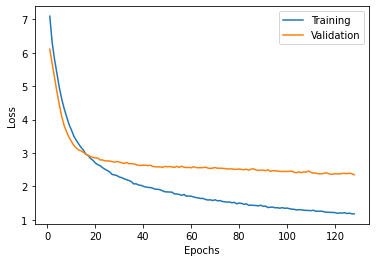

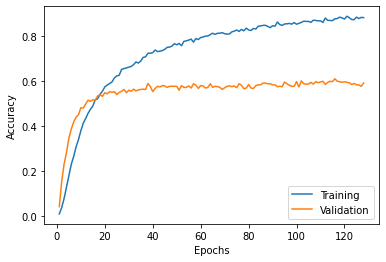

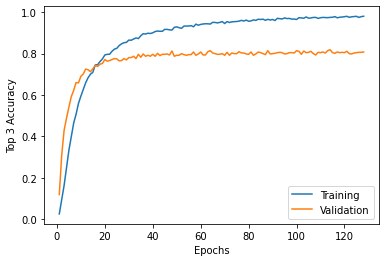

In [ ]:
x_plot = list(range(1,n_epochs+1))
plot_history(network_history)

From the graphs and especially from the results on the test set we can see that the model tends to underfit slightly. This condition has been preferred because of the better outcome obtained on the test set.

The results oscillate little above 60% in spite of the various modifications tried, this suggests that without more structural modifications this value represents a sort of threshold for the modalities with which the task has been faced.